# Virny Demo for the ACS Income Dataset

In this example, we are going to apply [Virny](https://github.com/DataResponsibly/Virny) to conduct a deep performance profiling for 5 models trained on the [ACS Income dataset](https://github.com/zykls/folktables). This demonstration will show how to create input arguments for Virny, how to compute overall and disparity metrics with a metric computation interface, and how to build static and interactive visualizations based on the calculated metrics. 

The structure of this notebook is the following:
* **Step 1**: Create a _config yaml_ for metric computation.
* **Step 2**: Preprocess a dataset and construct a _BaseFlowDataset_ object.
* **Step 3**: Tune models and create a _models config_.
* **Step 4**: Run a metric computation interface from Virny.
* **Step 5**: Compose disparity metrics using _Metric Composer_.
* **Step 6**: Create static visualizations using _Metric Static Visualizer_.
* **Step 7**: Build an interactive web app using _Metric Interactive Visualizer_.

To view other use case examples that demonstrate all Virny capabilities, you can go to [this webpage](https://dataresponsibly.github.io/Virny/examples/Multiple_Models_Interface_Use_Case/).

## Install necessary packages and import dependencies

In [24]:
# Install Virny using pypi. The library supports Python 3.8 and 3.9.
!pip install virny==0.5.0
!pip install xgboost==1.7.2

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [25]:
from pprint import pprint
from datetime import datetime, timezone

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.user_interfaces.multiple_models_api import compute_metrics_with_config
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.custom_classes.metrics_interactive_visualizer import MetricsInteractiveVisualizer
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.utils.model_tuning_utils import tune_ML_models

## **Step 1**: Create a _config yaml_ for metrics computation.

First, we need to create a _config yaml_, which includes the following parameters for metrics computation:

* **dataset_name**: str, a name of your dataset; it will be used to name files with metrics.

* **bootstrap_fraction**: float, the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **random_state**: int, a seed to control the randomness of the whole model evaluation pipeline.

* **n_estimators**: int, the number of estimators for bootstrap to compute stability and uncertainty metrics.

* **sensitive_attributes_dct**: dict, a dictionary where keys are sensitive attribute names (including intersectional attributes), and values are disadvantaged values for these attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify disadvantaged values for intersectional groups since they will be derived from disadvantaged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.

In [5]:
config_yaml_path = os.path.join('.', 'experiment_config.yaml')
config_yaml_content = """
dataset_name: ACS_Income
bootstrap_fraction: 0.8
random_state: 42
n_estimators: 20  # Better to input the higher number of estimators than 100; this is only for this demonstration
sensitive_attributes_dct: {'SEX': '2', 'RAC1P': ['2', '3', '4', '5', '6', '7', '8', '9'], 'SEX & RAC1P': None}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [6]:
config = create_config_obj(config_yaml_path=config_yaml_path)
SAVE_RESULTS_DIR_PATH = os.path.join('.', 'results', f'{config.dataset_name}_Metrics_{datetime.now(timezone.utc).strftime("%Y%m%d__%H%M%S")}')

## **Step 2**: Preprocess a dataset and construct a _BaseFlowDataset_ object.

Second, we need to import a dataset and preprocess it. In this demonstration, we are working with the ACS Income dataset, but you can use [any data loader provided by Virny](https://dataresponsibly.github.io/Virny/api/overview/#datasets) or create yours as described in [this example](https://dataresponsibly.github.io/Virny/examples/Multiple_Models_Interface_Use_Case/#preprocess-the-dataset-and-create-a-baseflowdataset-class).

Note that if you get an error importing the ACS Income dataset, this means that it is not available for your geographic location. In this case, you can use VPN to overcome this issue.

Import the dataset.

In [7]:
from virny.datasets import ACSIncomeDataset

data_loader = ACSIncomeDataset(state=['GA'], year=2018, with_nulls=False,
                               subsample_size=15_000, subsample_seed=42)
data_loader.full_df.head()

SCHL COW MAR  OCCP POBP RELP SEX RAC1P  AGEP  WKHP  PINCP
0   23   7   3   230   36    0   1     1    55  55.0      1
1   16   1   5  4110   13    2   2     1    20  35.0      0
2   16   4   3  4130   51    0   2     1    59  30.0      0
3   18   4   1  4020   13    0   1     2    43  40.0      0
4   14   1   1  8300   20    1   2     2    33  20.0      0

Define preprocessing steps and initialize a column transformer.

In [8]:
column_transformer = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
    ('numerical_features', StandardScaler(), data_loader.numerical_columns),
])

Construct a BaseFlowDataset object.

In [9]:
DATASET_SPLIT_SEED = 42
MODELS_TUNING_SEED = 42
TEST_SET_FRACTION = 0.2

base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=config.sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

## **Step 3**: Tune models and create a _models config_.

Next, we need to construct a _models config_ that includes initialized models you want to profile with Virny. For that, the models should be tuned using the _tune_ML_models()_ function from Virny or in any other convenient way.

Note that the model name convention for the _models config_ is '<MODEL_TYPE>' or '<MODEL_TYPE>__<ANY_SUFFIX>' (with two underscores), for example, 'DecisionTreeClassifier' or 'DecisionTreeClassifier__alpha=0.6'. This convention is needed to create appropriate bar charts for model selection in the interactive web app.

Define models and hyper-parameters to tune using GridSearchCV from sklearn.

In [10]:
models_params_for_tuning = {
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            "max_depth": [20, 30],
            "min_samples_split" : [0.1],
            "max_features": ['sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=MODELS_TUNING_SEED),
        'params': {
            'penalty': ['l2'],
            'C' : [0.0001, 0.1, 1, 100],
            'solver': ['newton-cg', 'lbfgs'],
            'max_iter': [250],
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'weights' : ['uniform'],
            'algorithm' : ['auto'],
            'n_neighbors' : [3, 4, 5],
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            "max_depth": [10],
            "min_samples_leaf": [1],
            "n_estimators": [20, 50],
            "max_features": [0.6]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(random_state=MODELS_TUNING_SEED, verbosity=0),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [50],
            'max_depth': [5, 7],
            'lambda':  [10, 100]
        }
    }
}

Tune models using the _tune_ML_models()_ function from Virny and create the _models config_.

In [11]:
tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, dataset_name='ACS_Income', n_folds=3)
tuned_params_df

2024/06/02, 17:01:24: Tuning DecisionTreeClassifier...
2024/06/02, 17:01:26: Tuning for DecisionTreeClassifier is finished [F1 score = 0.689443059507747, Accuracy = 0.7349166666666668]

2024/06/02, 17:01:26: Tuning LogisticRegression...
2024/06/02, 17:01:35: Tuning for LogisticRegression is finished [F1 score = 0.7929754140358044, Accuracy = 0.8145000000000001]

2024/06/02, 17:01:35: Tuning KNeighborsClassifier...
2024/06/02, 17:01:37: Tuning for KNeighborsClassifier is finished [F1 score = 0.7499760379663827, Accuracy = 0.7724166666666666]

2024/06/02, 17:01:37: Tuning RandomForestClassifier...
2024/06/02, 17:01:40: Tuning for RandomForestClassifier is finished [F1 score = 0.7663327842026387, Accuracy = 0.7935833333333333]

2024/06/02, 17:01:40: Tuning XGBClassifier...
2024/06/02, 17:01:53: Tuning for XGBClassifier is finished [F1 score = 0.7754257292923424, Accuracy = 0.8003333333333332]


Dataset_Name              Model_Name  F1_Score  Accuracy_Score  \
0   ACS_Income  DecisionTreeClassifier  0.689443        0.734917   
1   ACS_Income      LogisticRegression  0.792975        0.814500   
2   ACS_Income    KNeighborsClassifier  0.749976        0.772417   
3   ACS_Income  RandomForestClassifier  0.766333        0.793583   
4   ACS_Income           XGBClassifier  0.775426        0.800333   

                                   Model_Best_Params  
0  {'criterion': 'entropy', 'max_depth': 20, 'max...  
1  {'C': 1, 'max_iter': 250, 'penalty': 'l2', 'so...  
2  {'algorithm': 'auto', 'n_neighbors': 5, 'weigh...  
3  {'max_depth': 10, 'max_features': 0.6, 'min_sa...  
4  {'lambda': 10, 'learning_rate': 0.1, 'max_dept...

In [12]:
pprint(models_config)

{'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       min_samples_split=0.1, random_state=42),
 'KNeighborsClassifier': KNeighborsClassifier(),
 'LogisticRegression': LogisticRegression(C=1, max_iter=250, random_state=42, solver='newton-cg'),
 'RandomForestClassifier': RandomForestClassifier(max_depth=10, max_features=0.6, n_estimators=20,
                       random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=10, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=N

## **Step 4**: Run a metric computation interface from Virny.

After that we need to input the _BaseFlowDataset_ object, _models config_, and _config yaml_ to a metric computation interface and execute it. The interface uses subgroup analyzers to compute different sets of metrics for each privileged and disadvantaged group. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Error Analyzer**, but it is easily extensible to any other analyzers. When the variance and error analyzers complete metric computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [13]:
metrics_dct = compute_metrics_with_config(base_flow_dataset, config, models_config, SAVE_RESULTS_DIR_PATH, notebook_logs_stdout=True)

Analyze multiple models:   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

View the computed metrics for one model.

In [14]:
sample_model_metrics_df = metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df.head(20)

Metric      overall     SEX_priv      SEX_dis   RAC1P_priv  \
0        Statistical_Bias     0.358675     0.380756     0.335571     0.368035   
1         Mean_Prediction     0.649340     0.605822     0.694878     0.622922   
2     Overall_Uncertainty     0.840542     0.865386     0.814545     0.857158   
3   Aleatoric_Uncertainty     0.754194     0.779763     0.727440     0.768220   
4                     Std     0.147406     0.149878     0.144821     0.151499   
5                     IQR     0.203188     0.204853     0.201446     0.212635   
6   Epistemic_Uncertainty     0.086348     0.085624     0.087105     0.088938   
7         Label_Stability     0.647967     0.600652     0.697476     0.599409   
8                  Jitter     0.246075     0.279682     0.210910     0.275395   
9                     TPR     0.472816     0.545741     0.356061     0.546392   
10                    TNR     0.945685     0.905556     0.979439     0.925040   
11                    PPV     0.819865     0.802784     0.865031     0.818533   
12                    FNR     0.527184     0.454259     0.643939     0.453608   
13                    FPR     0.054315     0.094444     0.020561     0.074960   
14               Accuracy     0.783333     0.756845     0.811050     0.780296   
15                     F1     0.599754     0.649765     0.504472     0.655332   
16         Selection-Rate     0.198000     0.280965     0.111187     0.255172   
17            Sample_Size  3000.000000  1534.000000  1466.000000  2030.000000   

     RAC1P_dis  SEX&RAC1P_priv  SEX&RAC1P_dis              Model_Name  \
0     0.339087        0.366738       0.319588  DecisionTreeClassifier   
1     0.704629        0.633631       0.725500  DecisionTreeClassifier   
2     0.805768        0.852220       0.783926  DecisionTreeClassifier   
3     0.724842        0.764880       0.702390  DecisionTreeClassifier   
4     0.138842        0.149567       0.136930  DecisionTreeClassifier   
5     0.183419        0.207214       0.183673  DecisionTreeClassifier   
6     0.080926        0.087340       0.081536  DecisionTreeClassifier   
7     0.749588        0.623000       0.769006  DecisionTreeClassifier   
8     0.184715        0.262096       0.168411  DecisionTreeClassifier   
9     0.248031        0.509290       0.182609  DecisionTreeClassifier   
10    0.981844        0.934478       0.989950  DecisionTreeClassifier   
11    0.828947        0.818981       0.840000  DecisionTreeClassifier   
12    0.751969        0.490710       0.817391  DecisionTreeClassifier   
13    0.018156        0.065522       0.010050  DecisionTreeClassifier   
14    0.789691        0.778046       0.808967  DecisionTreeClassifier   
15    0.381818        0.628032       0.300000  DecisionTreeClassifier   
16    0.078351        0.228790       0.048733  DecisionTreeClassifier   
17  970.000000     2487.000000     513.000000  DecisionTreeClassifier   

                                         Model_Params  Virny_Random_State  \
0   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
1   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
3   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
4   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
5   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
6   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
7   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
8   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
9   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
10  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
11  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
12  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...                  42   
13  {'ccp_alp

## **Step 5**: Compose disparity metrics using _Metric Composer_.

To compose disparity metrics, the _Metric Composer_ should be applied. **Metric Composer** is responsible for the second stage of the model audit. Currently, it computes our custom error disparity, stability disparity, and uncertainty disparity metrics, but extending it for new disparity metrics is very simple. We noticed that more and more disparity metrics have appeared during the last decade, but most of them are based on the same group specific metrics. Hence, such a separation of group specific and disparity metrics computation allows us to experiment with different combinations of group specific metrics and avoid group metrics recomputation for a new set of disparity metrics.

Read the computed metrics from a file created by the metric computation interface.

In [15]:
models_metrics_dct = read_model_metric_dfs(SAVE_RESULTS_DIR_PATH, model_names=list(models_config.keys()))

Compose disparity metrics using _MetricsComposer_.

In [16]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)
models_composed_metrics_df = metrics_composer.compose_metrics()

In [17]:
models_composed_metrics_df

Metric       SEX     RAC1P  SEX&RAC1P  \
0                Accuracy_Difference  0.054206  0.009395   0.030921   
1   Aleatoric_Uncertainty_Difference -0.052323 -0.043378  -0.062490   
2        Aleatoric_Uncertainty_Ratio  0.932899  0.943534   0.918301   
3   Epistemic_Uncertainty_Difference  0.001481 -0.008012  -0.005804   
4        Epistemic_Uncertainty_Ratio  1.017297  0.909916   0.933545   
..                               ...       ...       ...        ...   
90                  Disparate_Impact  0.576996  0.530692   0.481141   
91                    Std_Difference -0.008166 -0.004115  -0.009956   
92                         Std_Ratio  0.829739  0.909165   0.782017   
93                Equalized_Odds_TNR  0.080789  0.059151   0.061232   
94                Equalized_Odds_TPR -0.085436 -0.196089  -0.187265   

                Model_Name  
0   DecisionTreeClassifier  
1   DecisionTreeClassifier  
2   DecisionTreeClassifier  
3   DecisionTreeClassifier  
4   DecisionTreeClassifier  
..                     ...  
90           XGBClassifier  
91           XGBClassifier  
92           XGBClassifier  
93           XGBClassifier  
94           XGBClassifier  

[95 rows x 5 columns]

## **Step 6**: Create static visualizations using _Metric Static Visualizer_.

**Metric Static Visualizer** allows us to build static visualizations for the computed metrics. It unifies different preprocessing methods for the computed  metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the _MetricsVisualizer_ class and get custom plots for diverse metric analysis.

In [18]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

In [19]:
visualizer.create_overall_metrics_bar_char(
    metric_names=['Accuracy', 'F1', 'Label_Stability', 'Std', 'Aleatoric_Uncertainty', 'Overall_Uncertainty'],
    plot_title="Overall Metrics"
)

alt.Chart(...)

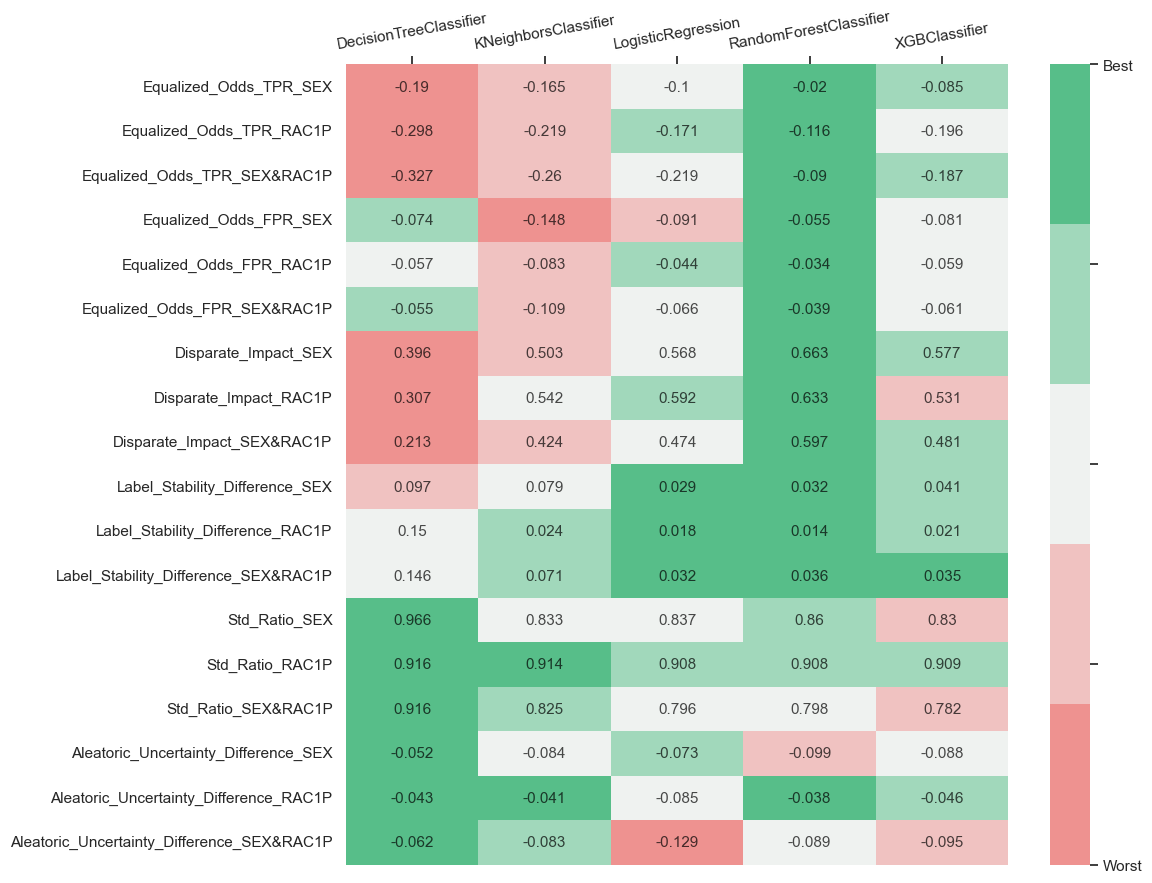

In [20]:
visualizer.create_disparity_metric_heatmap(
    model_names=list(models_params_for_tuning.keys()),
    metrics_lst=[
        # Error disparity metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        # Stability disparity metrics
        'Label_Stability_Difference',
        'Std_Ratio',
        # Uncertainty disparity metrics
        'Aleatoric_Uncertainty_Difference',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
    tolerance=0.005,
    figsize_scale=(0.6, 0.5),
    font_increase=-5,
)

## **Step 7**: Build an interactive web app using _Metric Interactive Visualizer_.

Finally, user can apply _Metric Interactive Visualizer_ to create an interactive web application that guides responsible model selection process and generates a nutritional label for the selected model.

In [21]:
interactive_metrics_visualizer = MetricsInteractiveVisualizer(X_data=data_loader.X_data,
                                                              y_data=data_loader.y_data,
                                                              model_metrics=models_metrics_dct,
                                                              sensitive_attributes_dct=config.sensitive_attributes_dct)

In [23]:
interactive_metrics_visualizer.create_web_app()